In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import arviz as az
from pymob import Config
from pymob.sim.plot import SimulationPlot
import matplotlib as mpl

from hierarchical_molecular_tktd.sim import (
    NomixHierarchicalSimulation, 
    plot_y0
)

config = Config("../scenarios/hierarchical_cext_nested_sigma_hyperprior_rna_pulse_5/settings.cfg")
config.case_study.package = "../.."
config.case_study.data_path = "../../tktd_rna_pulse/data"
sim = NomixHierarchicalSimulation(config)
sim.setup()
sim.dispatch_constructor()
sim.set_inferer("numpyro")
sim.inferer.load_results("numpyro_svi_posterior.nc")

/home/flo-schu/projects/pymob/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)
Results directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/results/hierarchical_cext_nested_sigma_hyperprior_rna_pulse_5'.
Scenario directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/scenarios/hierarchical_cext_nested_sigma_hyperprior_rna_pulse_5'.
Jax 64 bit mode: False
Absolute tolerance: 1e-05


In [2]:
# experiments = [19, 12, 26, 34, 36, 44, 41, 47]
# experiments = [19, 12, 26]
experiments = [19, 36, 44] # diuron
sim.observations = sim.observations.where(sim.observations.experiment_id.isin(experiments), drop=True)

sim.model_parameters["y0"] = sim.parse_input("y0", reference_data=sim.observations, drop_dims=["time"])

MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)


In [3]:
sim.coordinates["time"] = np.linspace(24, 120, 1000)
sim.dispatch_constructor()

In [4]:
def dataset_to_dict(dataset: xr.Dataset):
    return {k: v.values for k, v in dataset.data_vars.items()}
    
from pymob.solvers.base import mappar

# TODO: Use this method for Simulation base (getting the free_ode_params)
ode_params = mappar(sim.model, {}, to="names", exclude=sim.config.solverbase.exclude_kwargs_model)
free_params = list(sim.config.model_parameters.free.keys())

free_ode_params = list(set(ode_params).intersection(set(free_params)))

ode_parameters = sim.inferer.idata.posterior[free_ode_params]

y0 = sim.inferer.idata.posterior["cext_y0"]

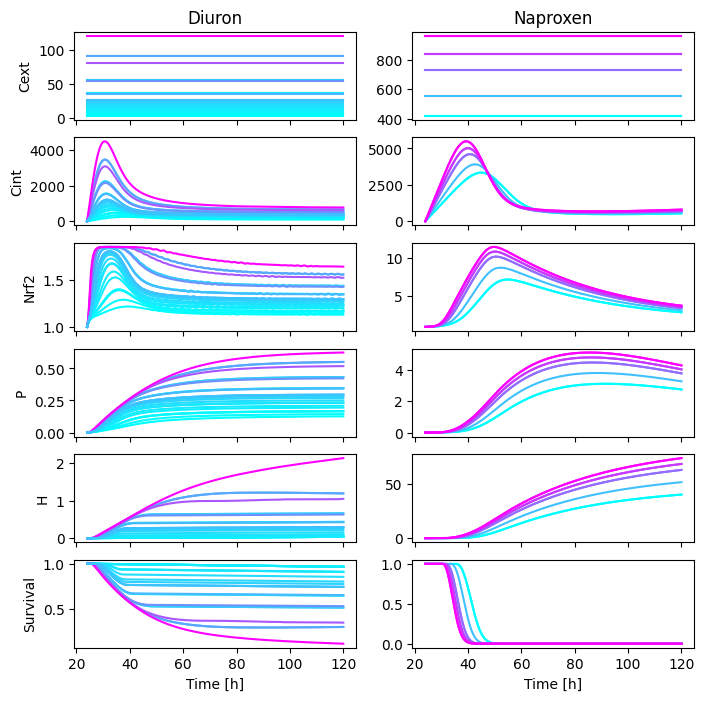

In [5]:

obs = sim.observations
theta_mean = ode_parameters.sel(id=obs.id).mean(("chain", "draw"))
y0_mean = y0.sel(id=obs.id).mean(("chain", "draw"))

e = sim.dispatch(
    theta=dataset_to_dict(theta_mean),
    y0={"cext": y0_mean.values},
)
e()

res = e.results

res
sim.plot(res)

In [6]:
cimax = sim.config.model_parameters.value_dict["ci_max_substance"][0]

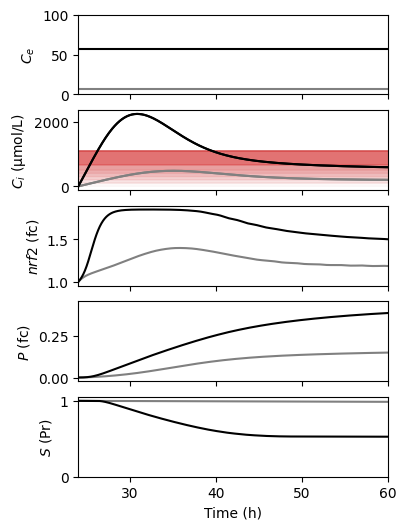

In [13]:
ids = obs.id.isel(id=[0,6]).values
fig, axes = plt.subplots(5,1, sharex=True, figsize=(4,6))
for i, color in zip(ids, ["grey", "black"]):
    z_ci = az.hdi(ode_parameters["z_ci"].sel(id=i)) * cimax
    z_ci_mean = ode_parameters["z_ci"].sel(id=i).mean() * cimax
    v_rt = ode_parameters["v_rt"].sel(id=i).mean()

    1 / (1 + np.exp(float(v_rt) * -(np.linspace(1,1800, 2)/cimax - float(z_ci_mean)/cimax)))


    r = res.sel(id=i)
    o = obs.sel(id=i)


    axes[0].plot(r.time, r.cext.T, color=color)
    axes[1].plot(r.time, r.cint.T, color=color)
    axes[1].plot(r.time, r.cint.T, color=color)
    axes[2].plot(r.time, r.nrf2.T, color=color)
    axes[3].plot(r.time, r.P.T, color=color)
    axes[4].plot(r.time, r.survival.T, color=color)
    axes[1].fill_between(r.time, 0, z_ci.z_ci.T[1], color="tab:red", alpha=.01)
    axes[1].fill_between(r.time, 100, z_ci.z_ci.T[1], color="tab:red", alpha=.05)
    axes[1].fill_between(r.time, 200, z_ci.z_ci.T[1], color="tab:red", alpha=.05)
    axes[1].fill_between(r.time, 300, z_ci.z_ci.T[1], color="tab:red", alpha=.05)
    axes[1].fill_between(r.time, 400, z_ci.z_ci.T[1], color="tab:red", alpha=.05)
    axes[1].fill_between(r.time, 500, z_ci.z_ci.T[1], color="tab:red", alpha=.05)
    axes[1].fill_between(r.time, *z_ci.z_ci.T, color="tab:red", alpha=.2)


    axes[0].set_ylabel(r"$C_e$")
    axes[1].set_ylabel(r"$C_i$ (µmol/L)")
    axes[2].set_ylabel(r"$nrf2$ (fc)")
    axes[3].set_ylabel(r"$P$ (fc)")
    axes[4].set_ylabel(r"$S$ (Pr)")
    axes[4].set_xlabel("Time (h)")
    axes[0].set_ylim(0,100)
    axes[4].set_ylim(0,1.05)
    axes[2].set_xlim(24,60)


/home/flo-schu/miniconda3/envs/damage-proxy/lib/python3.11/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


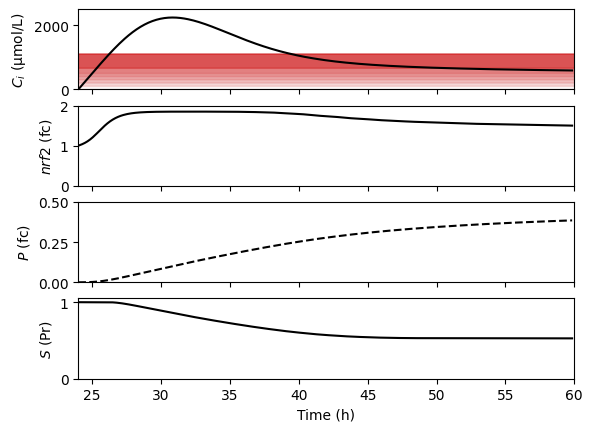

In [59]:
from matplotlib.animation import FuncAnimation

fig, axes = plt.subplots(4,1, sharex=True)
lines = []

# Initialize lines for each axis
for j, ax in enumerate(axes):
    if j == 2:
        line, = ax.plot([], [], ls="--", color="black")
    else:
        line, = ax.plot([], [], color="black")
    lines.append(line)

# Define init function to set up the background
def init():
    # axes[0].fill_between(r.time, *z_ci.z_ci.T, color="tab:red", alpha=.5)
    axes[0].fill_between(r.time, 0, z_ci.z_ci.T[1], color="tab:red", alpha=.01)
    axes[0].fill_between(r.time, 100, z_ci.z_ci.T[1], color="tab:red", alpha=.05)
    axes[0].fill_between(r.time, 200, z_ci.z_ci.T[1], color="tab:red", alpha=.05)
    axes[0].fill_between(r.time, 300, z_ci.z_ci.T[1], color="tab:red", alpha=.05)
    axes[0].fill_between(r.time, 400, z_ci.z_ci.T[1], color="tab:red", alpha=.05)
    axes[0].fill_between(r.time, 500, z_ci.z_ci.T[1], color="tab:red", alpha=.05)
    axes[0].fill_between(r.time, *z_ci.z_ci.T, color="tab:red", alpha=.2)
    axes[0].set_ylabel(r"$C_i$ (µmol/L)")
    axes[1].set_ylabel(r"$nrf2$ (fc)")
    axes[2].set_ylabel(r"$P$ (fc)")
    axes[3].set_ylabel(r"$S$ (Pr)")
    axes[3].set_xlabel("Time (h)")
    axes[0].set_ylim(0, 2500)
    axes[1].set_ylim(0, 2)
    axes[2].set_ylim(0, 0.5)
    axes[3].set_ylim(0, 1.05)
    axes[3].set_xlim(24, 60)  # Specific x-limits for the nrf2 plot
    return lines

# Update function for animation
def update(frame):
    for i, (line, data) in enumerate(zip(lines, [r.cint, r.nrf2, r.P, r.survival])):
        line.set_data(r.time.values[:frame], data.values[0][:frame])  # or set any other data
        axes[i].relim()  # Recalculate limits
        axes[i].autoscale_view()  # Rescale

    return lines

# Create an animation
ani = FuncAnimation(fig, update, frames=int((r.time <=60).sum().values), init_func=init, blit=True)
# ani = FuncAnimation(fig, update, frames=20, init_func=init, blit=True)

# ani.save(f'{sim.output_path}/animated_plot.mp4', writer='ffmpeg', fps=10)
ani.save(f'{sim.output_path}/animated_plot_10fps.avi', writer='ffmpeg', fps=10)

# axes[0].plot(o.time, o.cext.T, marker="o", ls="",color="black")
# axes[1].plot(o.time, o.cint.T, marker="o", ls="",color="black")
# axes[2].plot(o.time, o.nrf2.T, marker="o", ls="",color="black")
# axes[3].plot(o.time, o.survival.T, marker="o", ls="",color="black")

In [ ]:
res = res.assign_coords({"substance": sim.observations.substance})
cmap = mpl.colormaps["cool"]

col_dim = "substance"

ncols = sim.dimension_sizes[col_dim]
norws = sim.config.data_structure.all

sim.dimension_sizes
fig, axes = plt.subplots(4, ncols, sharex=True, figsize=(15,10))



for r, (v, vdict) in enumerate(data_structure.items()):
    for c, (s, sdict) in enumerate(vdict["substances"].items()):
        sdata = sim.observations.where(sim.observations.substance == s, drop=True)
        C = np.round(sdata.cext_nom.values, 1)
        norm = mpl.colors.Normalize(vmin=C.min(), vmax=C.max())
        for eid in sdict["experiment_ids"]:

            ax, meta, obs_ids, _ = sim._plot.plot_experiment(
                self=sim,
                experiment_id=eid,
                substance=s,
                data_var=v,
                cmap=cmap,
                norm=norm,
                ax=axes[r, c]
            )

            if v != "survival":
                ax.set_xlabel("")

            if v == "P":
                ax.set_ylabel("Protein")
                ax.spines[["right", "top"]].set_visible(False)

            if v == "nrf2":
                ax.set_ylim(0, 4)
                # note that the thresholds are mixed up. Diuron and Diclofenac should swap
                z = sim.inferer.idata.posterior.z.mean(("chain", "draw")).values
                ax.hlines(z[c], -10, 120, color="black", lw=0.5)

            if c != 0:
                ax.set_ylabel("")

            l = ax.get_legend()
            if l is not None:
                l.remove()
            if v == "cext":
                ax.set_title(s.capitalize())
            else:
                ax.set_title("")

            res_ids = sim.get_ids(res, {"substance": s, "experiment_id": eid})

            for i in res_ids:
                y = res.sel(id=i)
                ax.plot(res.time, y[v], color=cmap(norm(y.cext.isel(time=0))))
